In [22]:
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt


In [23]:
model_path = "pb"
model = tf.saved_model.load(model_path)
movenet = model.signatures['serving_default']


In [24]:
LEFT_ELBOW_IDX = 7
RIGHT_ELBOW_IDX = 8


In [25]:
with open('punch_coordinates2.txt', 'w') as f:

    # Read the video file.
    cap = cv2.VideoCapture('video2.mp4')

    while True:
        # Read a frame from the video.
        ret, frame = cap.read()

        if not ret:
            # End of video.
            break

        # Get the frame width and height.
        frame_height, frame_width, _ = frame.shape

        # Resize and pad the image to fit the expected input shape.
        image = tf.expand_dims(frame, axis=0)
        image = tf.cast(tf.image.resize_with_pad(
            image, 192, 192), dtype=tf.int32)

        # Run model inference.
        outputs = movenet(image)

        # Get the keypoint coordinates and confidence scores.
        keypoints = np.squeeze(outputs['output_0'])

        # Get the coordinates of the left and right elbows.
        left_elbow_coords = None
        right_elbow_coords = None

        if keypoints.ndim == 2:
            # If only one person is detected in the frame.
            if LEFT_ELBOW_IDX < keypoints.shape[0]:
                left_elbow_coords = (int(keypoints[LEFT_ELBOW_IDX][1] * frame_width), int(
                    keypoints[LEFT_ELBOW_IDX][0] * frame_height))
            if RIGHT_ELBOW_IDX < keypoints.shape[0]:
                right_elbow_coords = (int(keypoints[RIGHT_ELBOW_IDX][1] * frame_width), int(
                    keypoints[RIGHT_ELBOW_IDX][0] * frame_height))

        elif keypoints.ndim == 3:
            # If multiple people are detected in the frame, use the person with the highest confidence score.
            max_score_idx = np.argmax(keypoints[:, :, 2])
            if LEFT_ELBOW_IDX < keypoints.shape[1]:
                left_elbow_coords = (int(
                    keypoints[max_score_idx, LEFT_ELBOW_IDX][1] * frame_width), int(keypoints[max_score_idx, LEFT_ELBOW_IDX][0] * frame_height))
            if RIGHT_ELBOW_IDX < keypoints.shape[1]:
                right_elbow_coords = (int(
                    keypoints[max_score_idx, RIGHT_ELBOW_IDX][1] * frame_width), int(keypoints[max_score_idx, RIGHT_ELBOW_IDX][0] * frame_height))

        # Save the coordinates of both elbows in the file.
        if left_elbow_coords is not None and right_elbow_coords is not None:
            f.write(f"{left_elbow_coords},{right_elbow_coords}\n")

    # Release the video capture object.
    cap.release()


In [26]:
def plot_punch_dynamics(file_path):
    with open(file_path, 'r') as f:
        data = f.read()

    # Parse elbow coordinates from the string data
    data = data.split('\n')
    x_l = [int(d.split(',')[0][1:]) for d in data[:-1]]
    y_l = [int(d.split(',')[1][1:-1]) for d in data[:-1]]
    x_r = [int(d.split(',')[2][1:]) for d in data[:-1]]
    y_r = [int(d.split(',')[3][1:-1]) for d in data[:-1]]

    # Calculate velocity vectors and plot them
    dx_l = [x_l[i+1] - x_l[i] for i in range(len(x_l)-1)]
    dy_l = [y_l[i+1] - y_l[i] for i in range(len(y_l)-1)]
    dx_r = [x_r[i+1] - x_r[i] for i in range(len(x_r)-1)]
    dy_r = [y_r[i+1] - y_r[i] for i in range(len(y_r)-1)]
    plt.plot(dx_l, dy_l, label='Left Elbow')
    plt.plot(dx_r, dy_r, label='Right Elbow')

    # Plot settings
    plt.title('Punch Dynamics')
    plt.xlabel('Delta X')
    plt.ylabel('Delta Y')
    plt.legend()
    plt.show()


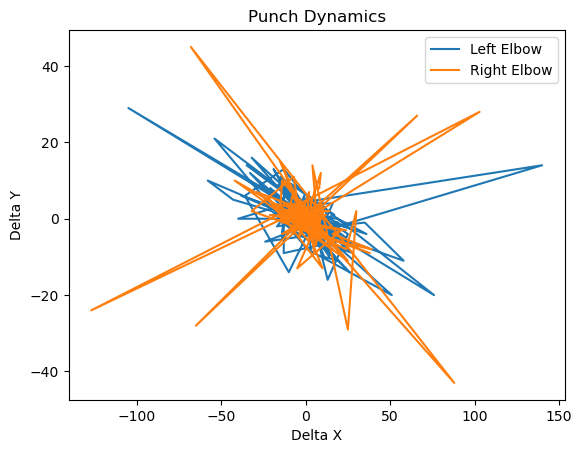

In [21]:
plot_punch_dynamics("punch_coordinates.txt")


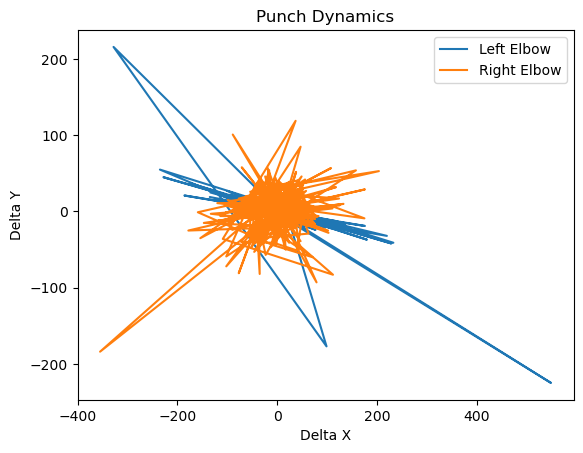

In [27]:
plot_punch_dynamics("punch_coordinates2.txt")


In [39]:
def plot_punch_dynamics2(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        data = f.readlines()

    left_elbow_coords = []
    right_elbow_coords = []

    for line in data:
        coords = line.strip().split(',')
        left_elbow_coords.append(float(coords[0].strip('()')))
        right_elbow_coords.append(float(coords[1].strip('()')))

    # Use linear interpolation to approximate the punch dynamics.
    x = np.linspace(0, len(left_elbow_coords), num=len(
        left_elbow_coords), endpoint=False)

    left_elbow_interp = np.interp(
        x, range(len(left_elbow_coords)), left_elbow_coords)
    right_elbow_interp = np.interp(
        x, range(len(right_elbow_coords)), right_elbow_coords)

    # Plot the graph.
    plt.plot(x, left_elbow_interp, label='Left elbow')
    plt.plot(x, right_elbow_interp, label='Right elbow')
    plt.legend()
    plt.xlabel('Frame number')
    plt.ylabel('Elbow coordinate')
    plt.title('Dynamics of the punch')
    plt.show()


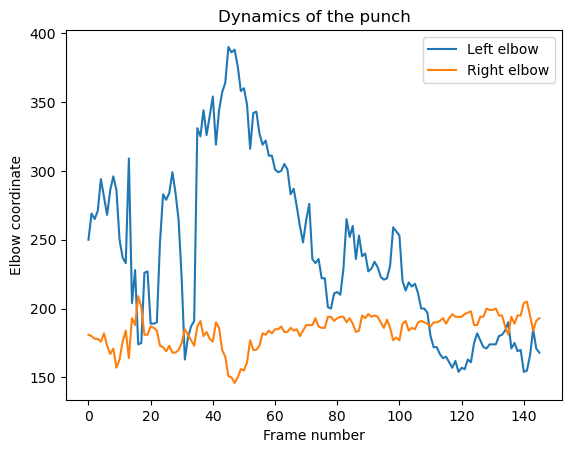

In [41]:
plot_punch_dynamics2("punch_coordinates.txt")


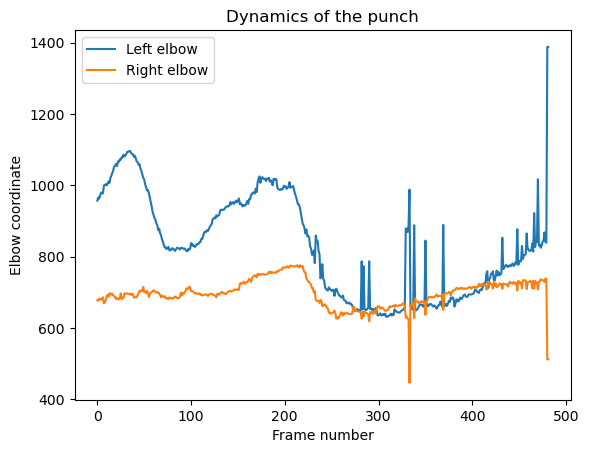

In [42]:
plot_punch_dynamics2("punch_coordinates2.txt")


In [47]:
def plot_punch_action(file_path):
    with open(file_path, 'r') as f:
        data = f.read()

    data = data.strip().split('\n')
    left_elbow_coords = []
    right_elbow_coords = []
    for line in data:
        coords = line.split(',')
        left_coords = tuple(map(int, coords[0].strip()[1:-1].split()))
        right_coords = tuple(map(int, coords[1].strip()[1:-1].split()))
        left_elbow_coords.append(left_coords)
        right_elbow_coords.append(right_coords)

    # Calculate the velocity and direction of the punch based on the elbow coordinates.
    velocities = []
    directions = []
    for i in range(len(left_elbow_coords) - 1):
        # Calculate the displacement vector.
        disp_vector = (right_elbow_coords[i][0] - left_elbow_coords[i]
                       [0], right_elbow_coords[i][1] - left_elbow_coords[i][1])

        disp_mag = (disp_vector[0]**2 + disp_vector[1]**2)**0.5
        if disp_mag == 0:
            # If the displacement magnitude is 0, assume the punch is stationary.
            velocities.append(0)
            directions.append(0)
        else:
            # Calculate the velocity and direction of the punch.
            time_delta = 0.0333  # Time between frames in seconds.
            velocity = disp_mag / time_delta
            direction = (180 / 3.14159) * (3.14159 / 2 -
                                           abs(disp_vector[1] / disp_mag)) * (disp_vector[0] / abs(disp_vector[0]))
            velocities.append(velocity)
            directions.append(direction)

    # Smooth the velocity and direction data using a moving average filter.
    window_size = 5
    velocities_smooth = [sum(velocities[i:i+window_size]) /
                         window_size for i in range(len(velocities)-window_size+1)]
    directions_smooth = [sum(directions[i:i+window_size]) /
                         window_size for i in range(len(directions)-window_size+1)]

    # Plot the punch action.
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    ax1.plot([coord[0] for coord in left_elbow_coords], label='Left Elbow')
    ax1.plot([coord[0] for coord in right_elbow_coords], label='Right Elbow')
    ax1.set_xlabel('Frame Number')
    ax1.set_ylabel('X Coordinate')
    ax1.legend()

    ax2.plot(velocities_smooth, label='Velocity')
    ax2.plot(directions_smooth, label='Direction')
    ax2.set_xlabel('Frame Number')
    ax2.set_ylabel('Measurement Value')
    ax2.legend()

    plt.show()


In [48]:
plot_punch_action("punch_coordinates.txt")


IndexError: tuple index out of range